In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from datetime import datetime
import pymongo
from pymongo import MongoClient
from wordcloud import WordCloud
import time
import numpy as np
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [11]:
''' Build DataFrame from MongoDB data '''

def load_data_mongo():
    
        ''' Read the Credentials '''

        config_file = open('config.txt','r')
        connect_str = config_file.read()

        ''' Connect using PyMongo Driver and load Data '''
        client = pymongo.MongoClient(connect_str)
        db = client.kick
        collection = db.project
        df = pd.DataFrame(list(collection.find()))
        config_file.close()
        return df

# Exploratory Analysis 

C:\Users\uvxb512\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\uvxb512\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\uvxb512\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


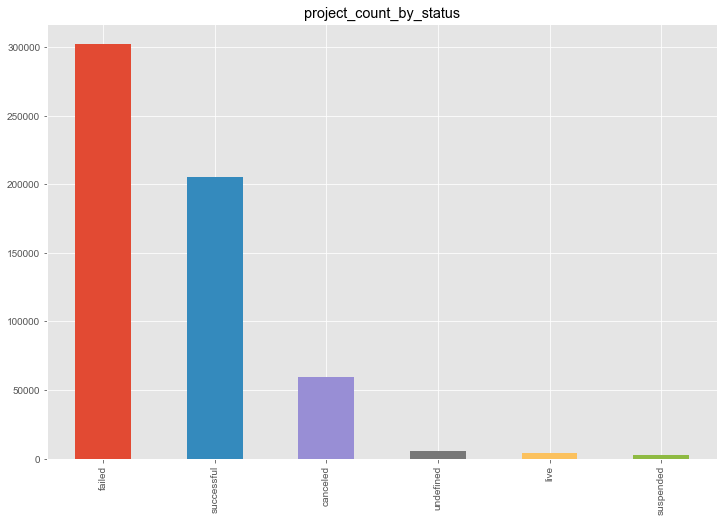

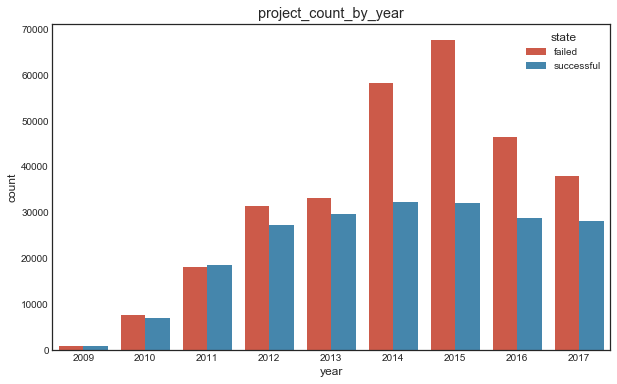

<Figure size 720x432 with 0 Axes>

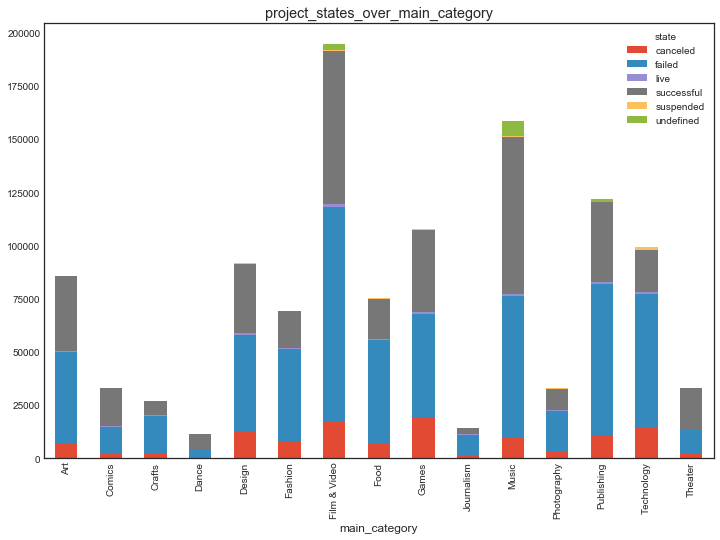

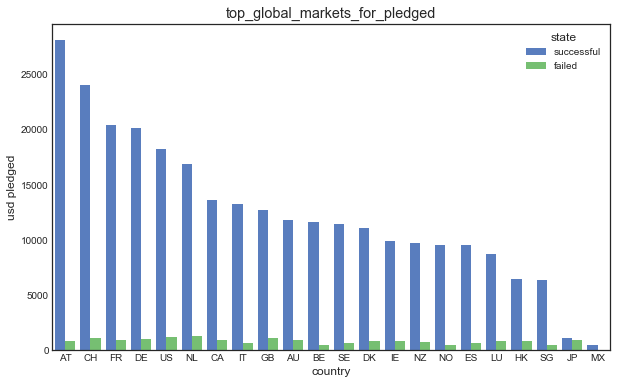

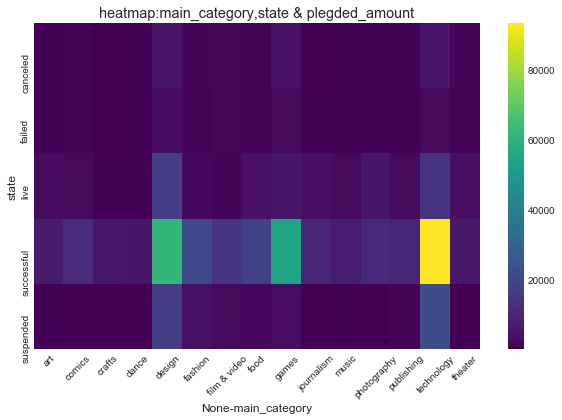

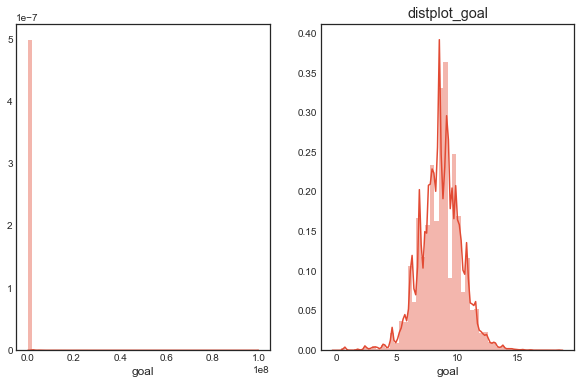

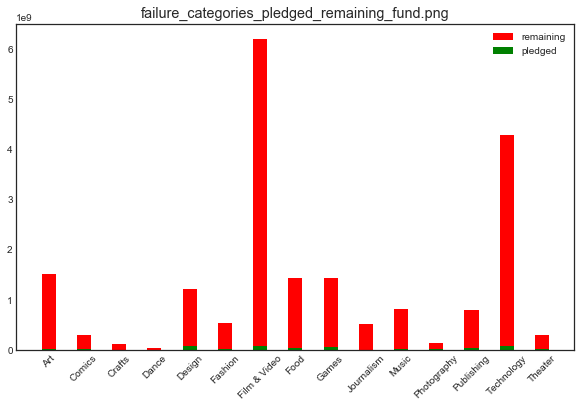

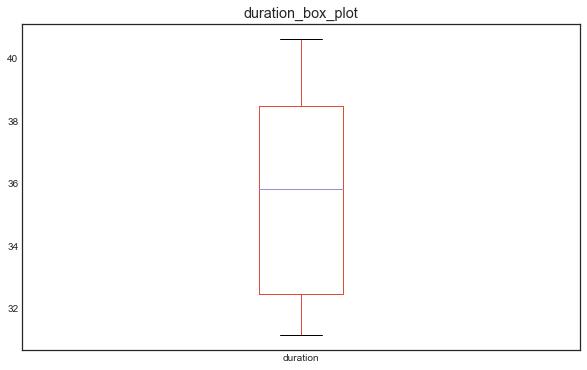

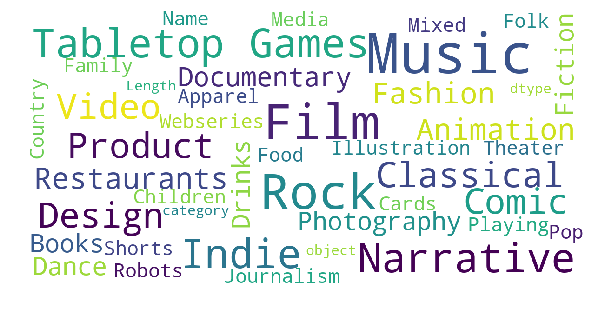

In [4]:
def show_wordcloud(data, title = None):
    
    # ------- Split names by space and generate word counts. -------- #
    
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin it was heads
    ).generate(str(data))

    fig = plt.figure(figsize =(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    return plt.imshow(wordcloud)

def load_data():
    
    #df = pd.read_csv("ks-projects-201801.csv")
    
    ''' Load data from MongoDB '''
    
    df = load_data_mongo()     
    
    
    #df.drop(['usd pledged'], axis=1, inplace=True)

    df.replace('N,0"','NO',inplace=True)

    ''' Launched date conversion to day,year,month,time'''
    
    df['year'] = df['launched'].apply(lambda x:x[0:4])                                                                                                                                                                                                                                          
    df['month'] = df['launched'].apply(lambda x:x[5:7])
    df['day'] = df['launched'].apply(lambda x:x[8:10])
    df['time'] = df['launched'].apply(lambda x:x[11:])

    # --- Deadline date conversion to day,year,month,time --- #
    
    df['year_d'] = df['deadline'].apply(lambda x:x[0:4])                                                                                                                                                                                                                                          
    df['month_d'] = df['deadline'].apply(lambda x:x[5:7])
    df['day_d'] = df['deadline'].apply(lambda x:x[8:10])
    df['time_d'] = df['deadline'].apply(lambda x:x[11:])

    df['A'] = pd.to_datetime(df['deadline'])
    df['B'] = pd.to_datetime(df['launched'])
    df['duration'] = df['A'] - df['B']
    df.duration = df.duration.dt.days
    return df

def main():
    ''' Projects statuses count chart '''
    
    df = load_data()
    plt.style.use('ggplot')
    fig1 = plt.figure(figsize=(12,8))
    df['state'].value_counts().plot(kind='bar')
    plt.title('project_count_by_status')
    fig1.savefig('project_states_count.png')

    ''' Projects Count  by year chart '''
    
    sns.set_style('white')
    fig2 = plt.figure(figsize=(10,6))
    df3 = df[(df['state']=='successful')| (df['state']=='failed')].sort_values(by='pledged',ascending=True)
    sns.countplot(x='year',hue='state',data=df3)
    plt.title('project_count_by_year')
    fig2.savefig('project_count_by_year.png')

    ''' Projects states by category chart '''
    
    sns.set_style('white')
    fig3 = plt.figure(figsize=(10,6))
    df[['main_category', 'state']].pivot_table(columns='state', index='main_category', aggfunc=np.size).plot(kind='bar', figsize=(12, 8), stacked=True)
    plt.title('project_states_over_main_category')
    fig3.savefig('project_states_by_category.png')

    ''' Top global markets chart '''
    
    fig4 = plt.figure(figsize=(10,6))
    df_s = df[(df['state']=='successful')| (df['state']=='failed')]
    df_c = df_s[['usd pledged','state','country']]
    df_cp = df_c.groupby(['country','state'],as_index=False).mean().sort_values(by='usd pledged',ascending=False)
    sns.barplot(x='country',y='usd pledged',data=df_cp,hue='state',palette='muted')
    plt.title('top_global_markets_for_pledged')
    fig4.savefig('top_markes_for_pledged.png')
    
    ''' heatmap chart '''

    fig5 = plt.figure(figsize=(10,6))
    df_gn = df[['usd_pledged_real','state','main_category']]
    df_gn_g = df_gn.groupby(['main_category','state'],as_index=False).mean()
    df_pivot = df_gn_g.pivot(index='state',columns='main_category')
    df_pivot.dropna(inplace=True)
    labels = ['art','comics','crafts','dance','design','fashion','film & video','food','games','journalism','music','photography','publishing','technology','theater']
    g = sns.heatmap(df_pivot,cmap='viridis',xticklabels=labels)
    #plt.xticks(np.arange(0, 1, step=0.5))
    plt.xticks(rotation=45)
    plt.title('heatmap:main_category,state & plegded_amount')
    fig5.savefig('heatmap.png')
    
    
    ''' Distplot chart '''
   
    dims = (10,6)
    fig6, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=dims)
    sns.distplot(df.goal, ax=ax1)
    sns.distplot(np.log1p(df.goal), ax=ax2)
    plt.title('distplot_goal')
    fig6.savefig('distplot_goal.png')

    ''' Remaining fund chart '''
    
    fig7 = plt.figure(figsize=(10,6))
    df_r = df[df['state'] == 'failed'] 
    df_r['remain'] = df_r['goal']- df_r['pledged']
    df8 = (df_r.groupby(['main_category']).agg({'goal':'sum', 'pledged':'sum', 'remain':'sum'}).reset_index())
    #print(df8)
    ax = plt.axes()
    ax.bar(df8.main_category, df8['remain'], width=0.4, color='r',label = 'remaining')
    ax.bar(df8.main_category, df8['pledged'], width=0.4, color='g', label = 'pledged')
    plt.xticks(rotation=45)
    ax.legend(fontsize = 10)
    plt.title('failure_categories_pledged_remaining_fund.png')
    fig7.savefig('failure_categories_pledged_remaining_fund.jpg')
    
    ''' Duration box plot '''

    fig8 = plt.figure(figsize=(10,6))
    df4  = df.groupby('state').duration.mean().sort_index()
    df4.plot(kind='box')
    plt.title('duration_box_plot')
    fig8.savefig('duration_box_plot.png')
    
    show_wordcloud(df[df.state == 'successful']['category'])
main()

# Time series Analysis 

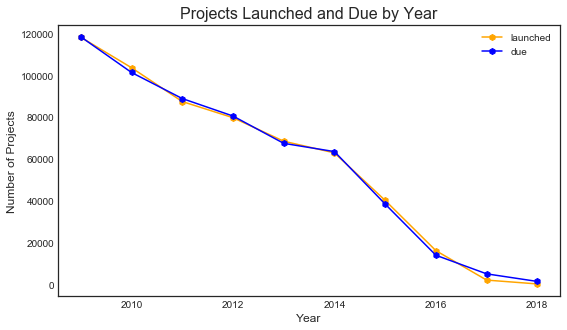

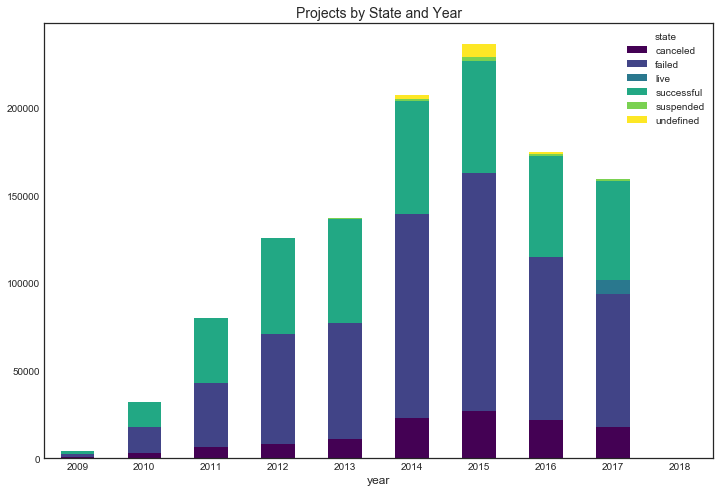

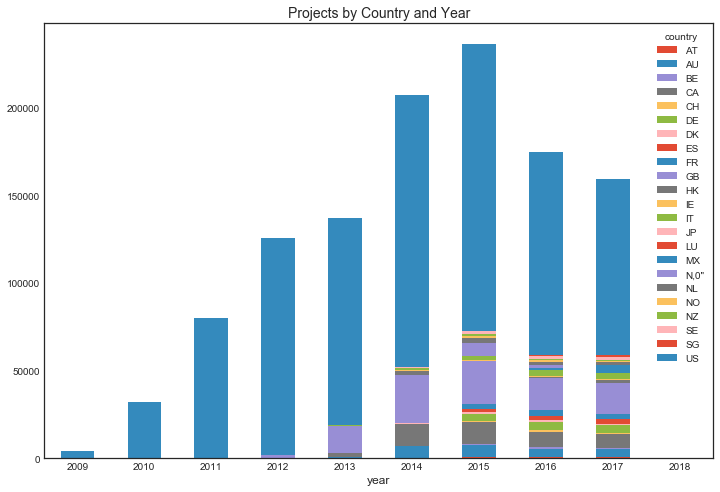

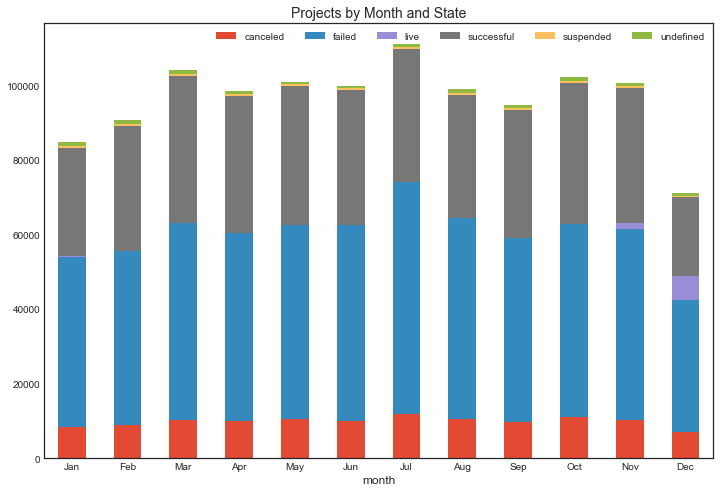

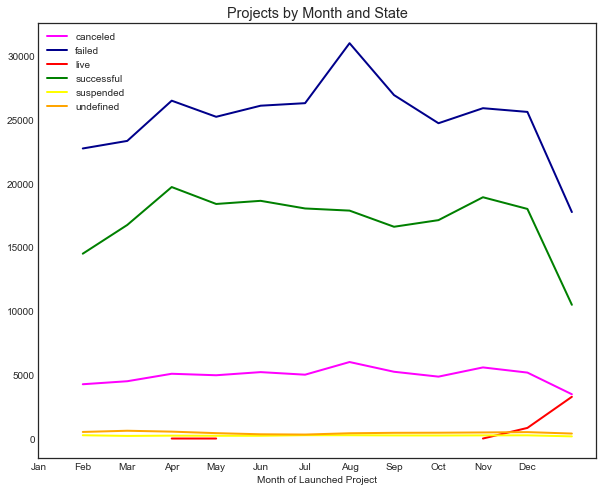

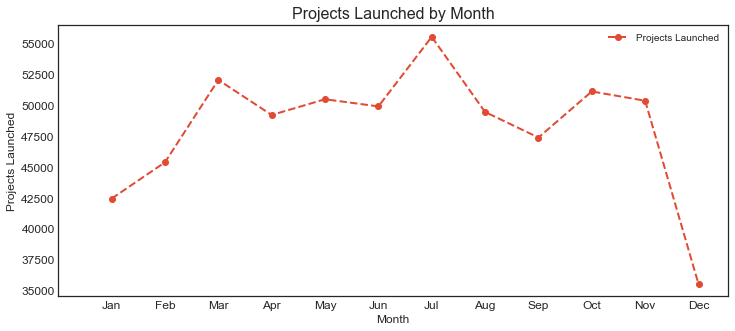

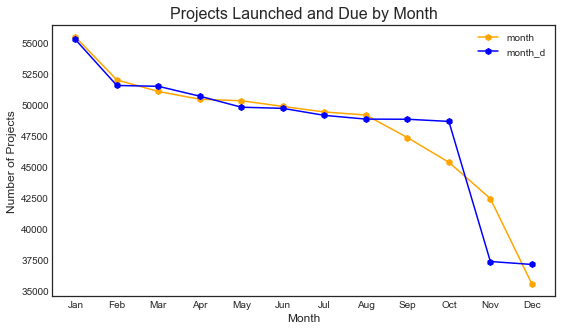

In [5]:
def time_series():
    ''' load data'''

    df = load_data_mongo()
    
    '''extract year and month from launched and deadline dates'''

    df['year'] = pd.to_datetime(df['launched']).dt.year
    df['month'] = pd.to_datetime(df['launched']).dt.month
    df['year_d'] = pd.to_datetime(df['deadline']).dt.year
    df['month_d'] = pd.to_datetime(df['deadline']).dt.month
    clean_df= df[df['year']!=1970]

    ''' plot number of launched and due projects by year '''
    
    fig=plt.figure(figsize=(9,5))
    labels = ['launched', 'due']

    year = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
    launched = clean_df['year'].value_counts()
    due= clean_df['year_d'].value_counts()

    plt.plot(year, launched, color='orange', marker="h")
    plt.plot(year, due, color='blue', marker="h")

    plt.xlabel('Year', fontsize = 12)
    plt.ylabel('Number of Projects', fontsize =12)
    plt.title('Projects Launched and Due by Year', fontsize=16)
    plt.legend(labels, loc='best')
    
    '''Save figure as png file'''
    
    plt.savefig("Time Series 1 - Launched and Due Projects by Year.png")
    
    '''Pivot data for year and states'''
    
    clean_df[['year', 'state']].pivot_table(columns='state', index='year', aggfunc=np.size).plot(kind='bar', figsize=(12, 8), stacked = True, colormap='viridis')
    plt.title("Projects by State and Year", fontsize = 14)
    plt.xticks(rotation='horizontal')

    plt.savefig("t2.png")
    
    '''Pivot data for year and country'''
    
    clean_df[['year', 'country']].pivot_table(columns='country', index='year', aggfunc=np.size).plot(kind='bar', figsize=(12, 8), stacked = True)
    plt.title("Projects by Country and Year", fontsize = 14)
    plt.xticks(rotation='horizontal')

    plt.savefig("Time Series 3 - Projects by Country and Year.png")

    proj_by_state_month = clean_df['launched'].groupby([clean_df['month'], df['state']]).count().unstack()

    '''Pivot data for month and state'''
    
    clean_df[['month', 'state']].pivot_table(columns='state', index='month', aggfunc=np.size).plot(kind='bar', figsize=(12, 8), stacked = True)
    plt.title("Projects by Month and State", fontsize = 14)
    plt.xticks(np.arange(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), rotation='horizontal')
    plt.legend(loc='best', ncol=6)

    plt.savefig("Time Series 4 - Projects by Month and State.png")

    '''group data by month and state'''
    
    by_month = clean_df['launched'].groupby([clean_df['month'], clean_df['state']]).count().unstack()

    mycolors =['magenta','darkblue', 'red', 'green', 'yellow', 'orange']
    by_month.plot(figsize=(10,8), title='Projects by Month and State', linewidth=2.0, color=mycolors)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.xticks(range(len(months)), months)
    plt.xlabel('Month of Launched Project', fontsize=10)
    plt.legend(loc='best')

    plt.savefig("Time Series 4 - Projects by State and Month.png")

    months = ['','Jan', 'Feb','Mar','Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct','Nov', 'Dec']
    by_month_all= clean_df.groupby('month').size().reset_index(name='Projects Launched').set_index('month')

    ax= by_month_all.plot(kind="line",figsize=(12,5), linestyle='--', marker='o', linewidth=2.0, markersize=6.0)
    plt.title("Projects Launched by Month", fontsize = 16)

    plt.xticks(range(len(months)), months)
    plt.ylabel("Projects Launched", fontsize=12)
    plt.xlabel("Month", fontsize=12)
    ax.tick_params(labelsize=12)

    plt.savefig("Time Series 5 - Projects Launched by Month.png")

    '''plot number of launched and due projects by month'''
    
    fig=plt.figure(figsize=(9,5))

    months = ['Jan', 'Feb','Mar','Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct','Nov', 'Dec']
    launched1 = clean_df['month'].value_counts()
    due1= clean_df['month_d'].value_counts()

    plt.plot(months, launched1, color='orange', marker="h")
    plt.plot(months, due1, color='blue', marker="h")

    plt.xlabel('Month', fontsize = 12)
    plt.ylabel('Number of Projects', fontsize =12)
    plt.title('Projects Launched and Due by Month', fontsize=16)
    plt.legend(loc='best')

    plt.savefig("Time Series 6 - Launched and Due Projects by Month.jpg")
time_series() 

Index(['backers', 'goal', 'main_category', 'duration'], dtype='object')
             precision    recall  f1-score   support

          0       0.88      0.96      0.91     52437
          1       0.93      0.81      0.86     36321

avg / total       0.90      0.89      0.89     88758

[0.90471845 0.89505171 0.8965727  0.89170371 0.89665371]
Average accuracy Score: 0.8969400561452225


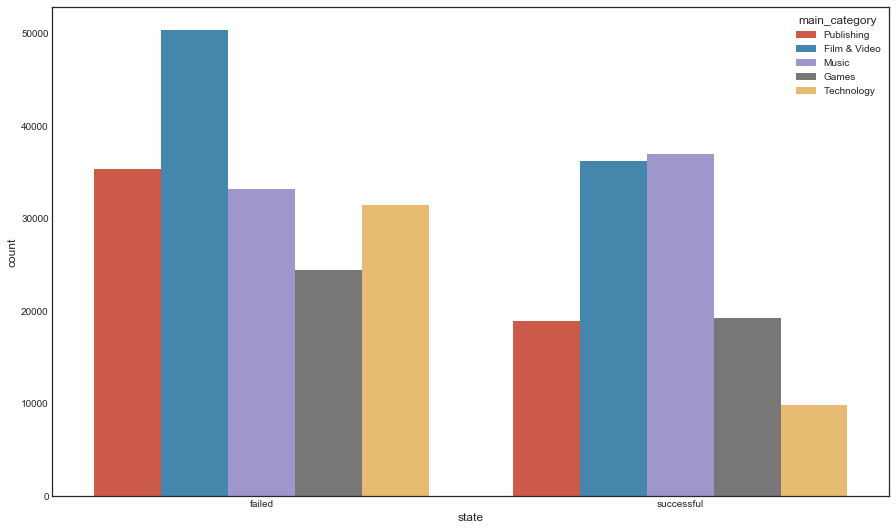

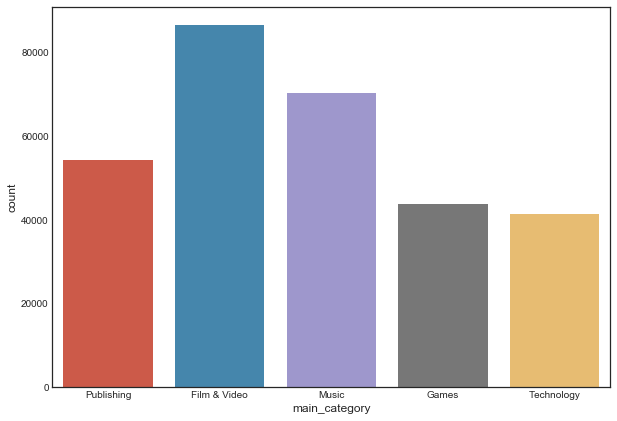

In [8]:
def logistic_regression():
    #df = pd.read_csv("ks-projects-201801.csv")
    ''' Load the data from MongoDB '''
    
    df = load_data_mongo()
    
    ''' Extract duration as a feature '''
    
    df['A'] = pd.to_datetime(df['deadline'])
    df['B'] = pd.to_datetime(df['launched'])
    df['duration'] = df['A'] - df['B']
    df.duration = df.duration.dt.days
    
    ''' Select only success and failed projects and drop unwanted columns '''

    df.drop(columns=['usd_pledged_real','usd_goal_real','usd pledged'],inplace=True)
    df_sf =df[(df['state'] == 'successful') | (df['state']=='failed')]
    
    ''' Select top five main categories '''
    
    df_sf['main_category'].value_counts().nlargest(5)
    df_sf_t = df_sf[df_sf['main_category'].isin(['Film & Video','Music','Technology','Publishing','Games'])]
    plt.figure(figsize=(15,9))
    sns.countplot(data=df_sf_t,x='state',hue='main_category')
    plt.savefig('top_5_categories_classes.png')

    plt.figure(figsize=(10,7))
    sns.countplot(x='main_category',data=df_sf_t)
    plt.savefig('selecting_top_5_categories.png')
    
    ''' Convert the state column to numeric vector and drop unwanted columns '''

    proj_state = pd.get_dummies(data=df_sf_t['state'], drop_first=True)
    df_sf_t = pd.concat([df_sf_t,proj_state],axis=1)
    df_sf_t.drop(columns=['ID','name','currency','pledged','A','B','country','deadline','launched'],inplace=True)
    df_sf_t.drop(columns=['category','state'],inplace=True)
    df_sf_t.drop(columns='_id',inplace=True)
    
    ''' Mapping main categories to numeric values '''

    cats= {'Publishing':4,'Film & Video':1,
        'Music':2,
        'Games':5,
        'Technology':3}

    df_sf_t['main_category'] = df_sf_t['main_category'].replace(cats)
    
    '''Get X, y data frame with extracted features '''
    
    X = df_sf_t.drop('successful',axis=1)
    print(X.columns)
    y = df_sf_t['successful']
    
    ''' Train test split dataset and create classifier object and fit data model'''

    from sklearn.cross_validation import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=100)
    from sklearn.linear_model import LogisticRegression
    log_model = LogisticRegression()
    log_model.fit(X_train,y_train)
    
    ''' Print results, predictions, accuracy scores '''

    predictions=log_model.predict(X_test)
    from sklearn.metrics import classification_report
    print(classification_report(y_test,predictions))

    from sklearn.metrics import confusion_matrix
    confusion_matrix(y_test,predictions)

    from sklearn.model_selection import cross_val_score
    cross_score = cross_val_score(log_model, X,y,scoring="accuracy", cv=5)
    avg_accuracy = np.mean(cross_score)
    print(cross_score)
    print("Average accuracy Score: " + str(avg_accuracy))
logistic_regression()